# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4523+g0a38639
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
ict_off = False
ecc_off = False

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=-0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.3426 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1677 seconds.
System internal structure set up in 0.0740 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


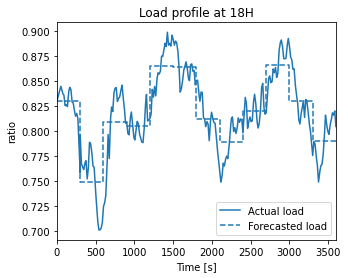

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1945 seconds.
0: |F(x)| = 9.101680411
1: |F(x)| = 3.497456414
2: |F(x)| = 0.1830766454
3: |F(x)| = 0.0007183029104
4: |F(x)| = 1.659286886e-08
Converged in 5 iterations in 0.0155 seconds.
Power flow results are consistent. Conversion is successful.


Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0076 seconds.
0: |F(x)| = 9.101680411
1: |F(x)| = 3.497456414
2: |F(x)| = 0.1830766454
3: |F(x)| = 0.0007183029104
4: |F(x)| = 1.659286886e-08
Converged in 5 iterations in 0.0087 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778915, gb cost=4889.131241556355


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.0313,39.9756,15.8831,1.0,970.0312
1,646.0000,228.9208,2.2281,1.0,646.0000
2,290.0000,81.0987,-0.8653,1.0,290.0000
3,652.0000,114.2245,7.2985,1.0,652.0000
4,508.0000,137.9576,5.4672,1.0,508.0000
5,646.6875,212.0871,6.4196,1.0,646.6875
6,232.0000,55.2884,3.4379,1.0,232.0000
7,564.0000,-59.8950,13.9534,1.0,564.0000
8,865.0000,49.8766,18.9462,1.0,865.0000
9,30.0000,49.8766,18.9462,1.0,30.0000


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 0.0, 0.0, 0.05

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [7]:
# %run -i 'cosim_bmain.py'

Loop

In [8]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4704.954
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0096 seconds.
0: |F(x)| = 7.905038032
1: |F(x)| = 3.816864876
2: |F(x)| = 0.2218538853
3: |F(x)| = 0.001780982337
4: |F(x)| = 7.782505262e-08
Converged in 5 iterations in 0.0131 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for

Simulation to t=124.00 sec completed in 0.1273 seconds.
Simulation to t=125.00 sec completed in 0.0784 seconds.
Simulation to t=126.00 sec completed in 0.0851 seconds.
Simulation to t=127.00 sec completed in 0.1027 seconds.
Simulation to t=128.00 sec completed in 0.0902 seconds.
Simulation to t=129.00 sec completed in 0.0950 seconds.
Simulation to t=130.00 sec completed in 0.0829 seconds.
Simulation to t=131.00 sec completed in 0.1139 seconds.
Simulation to t=132.00 sec completed in 0.0848 seconds.
Simulation to t=133.00 sec completed in 0.0769 seconds.
Simulation to t=134.00 sec completed in 0.0797 seconds.
Simulation to t=135.00 sec completed in 0.0772 seconds.
Simulation to t=136.00 sec completed in 0.0946 seconds.
Simulation to t=137.00 sec completed in 0.1256 seconds.
Simulation to t=138.00 sec completed in 0.0951 seconds.
Simulation to t=139.00 sec completed in 0.0883 seconds.
Simulation to t=140.00 sec completed in 0.0908 seconds.
Simulation to t=141.00 sec completed in 0.1188 s

Simulation to t=271.00 sec completed in 0.1147 seconds.
Simulation to t=272.00 sec completed in 0.1063 seconds.
Simulation to t=273.00 sec completed in 0.1038 seconds.
Simulation to t=274.00 sec completed in 0.1153 seconds.
Simulation to t=275.00 sec completed in 0.1074 seconds.
Simulation to t=276.00 sec completed in 0.1172 seconds.
Simulation to t=277.00 sec completed in 0.1430 seconds.
Simulation to t=278.00 sec completed in 0.0985 seconds.
Simulation to t=279.00 sec completed in 0.1365 seconds.
Simulation to t=280.00 sec completed in 0.1195 seconds.
Simulation to t=281.00 sec completed in 0.1629 seconds.
Simulation to t=282.00 sec completed in 0.1021 seconds.
Simulation to t=283.00 sec completed in 0.1130 seconds.
Simulation to t=284.00 sec completed in 0.1670 seconds.
Simulation to t=285.00 sec completed in 0.1083 seconds.
Simulation to t=286.00 sec completed in 0.1182 seconds.
Simulation to t=287.00 sec completed in 0.1123 seconds.
Simulation to t=288.00 sec completed in 0.1117 s

Simulation to t=417.00 sec completed in 0.1682 seconds.
Simulation to t=418.00 sec completed in 0.1541 seconds.
Simulation to t=419.00 sec completed in 0.1210 seconds.
Simulation to t=420.00 sec completed in 0.1784 seconds.
Simulation to t=421.00 sec completed in 0.1310 seconds.
Simulation to t=422.00 sec completed in 0.1259 seconds.
Simulation to t=423.00 sec completed in 0.1168 seconds.
Simulation to t=424.00 sec completed in 0.1588 seconds.
Simulation to t=425.00 sec completed in 0.1690 seconds.
Simulation to t=426.00 sec completed in 0.0849 seconds.
Simulation to t=427.00 sec completed in 0.0889 seconds.
Simulation to t=428.00 sec completed in 0.0862 seconds.
Simulation to t=429.00 sec completed in 0.1073 seconds.
Simulation to t=430.00 sec completed in 0.0991 seconds.
Simulation to t=431.00 sec completed in 0.0946 seconds.
Simulation to t=432.00 sec completed in 0.0921 seconds.
Simulation to t=433.00 sec completed in 0.0930 seconds.
Simulation to t=434.00 sec completed in 0.1071 s

Simulation to t=564.00 sec completed in 0.0972 seconds.
Simulation to t=565.00 sec completed in 0.0824 seconds.
Simulation to t=566.00 sec completed in 0.0939 seconds.
Simulation to t=567.00 sec completed in 0.0875 seconds.
Simulation to t=568.00 sec completed in 0.0847 seconds.
Simulation to t=569.00 sec completed in 0.0853 seconds.
Simulation to t=570.00 sec completed in 0.0849 seconds.
Simulation to t=571.00 sec completed in 0.0844 seconds.
Simulation to t=572.00 sec completed in 0.1031 seconds.
Simulation to t=573.00 sec completed in 0.0995 seconds.
Simulation to t=574.00 sec completed in 0.1060 seconds.
Simulation to t=575.00 sec completed in 0.1014 seconds.
Simulation to t=576.00 sec completed in 0.0940 seconds.
Simulation to t=577.00 sec completed in 0.1409 seconds.
Simulation to t=578.00 sec completed in 0.1538 seconds.
Simulation to t=579.00 sec completed in 0.1169 seconds.
Simulation to t=580.00 sec completed in 0.0798 seconds.
Simulation to t=581.00 sec completed in 0.1162 s

Simulation to t=710.00 sec completed in 0.0991 seconds.
Simulation to t=711.00 sec completed in 0.0842 seconds.
Simulation to t=712.00 sec completed in 0.0819 seconds.
Simulation to t=713.00 sec completed in 0.0861 seconds.
Simulation to t=714.00 sec completed in 0.0901 seconds.
Simulation to t=715.00 sec completed in 0.0867 seconds.
Simulation to t=716.00 sec completed in 0.0988 seconds.
Simulation to t=717.00 sec completed in 0.1084 seconds.
Simulation to t=718.00 sec completed in 0.1125 seconds.
Simulation to t=719.00 sec completed in 0.0850 seconds.
Simulation to t=720.00 sec completed in 0.1055 seconds.
Simulation to t=721.00 sec completed in 0.1292 seconds.
Simulation to t=722.00 sec completed in 0.1073 seconds.
Simulation to t=723.00 sec completed in 0.0886 seconds.
Simulation to t=724.00 sec completed in 0.0875 seconds.
Simulation to t=725.00 sec completed in 0.0980 seconds.
Simulation to t=726.00 sec completed in 0.1048 seconds.
Simulation to t=727.00 sec completed in 0.1048 s

Simulation to t=857.00 sec completed in 0.1136 seconds.
Simulation to t=858.00 sec completed in 0.1421 seconds.
Simulation to t=859.00 sec completed in 0.1144 seconds.
Simulation to t=860.00 sec completed in 0.1351 seconds.
Simulation to t=861.00 sec completed in 0.1188 seconds.
Simulation to t=862.00 sec completed in 0.1259 seconds.
Simulation to t=863.00 sec completed in 0.1332 seconds.
Simulation to t=864.00 sec completed in 0.0988 seconds.
Simulation to t=865.00 sec completed in 0.1283 seconds.
Simulation to t=866.00 sec completed in 0.1119 seconds.
Simulation to t=867.00 sec completed in 0.1233 seconds.
Simulation to t=868.00 sec completed in 0.1090 seconds.
Simulation to t=869.00 sec completed in 0.1338 seconds.
Simulation to t=870.00 sec completed in 0.1227 seconds.
Simulation to t=871.00 sec completed in 0.1265 seconds.
Simulation to t=872.00 sec completed in 0.1027 seconds.
Simulation to t=873.00 sec completed in 0.0982 seconds.
Simulation to t=874.00 sec completed in 0.0932 s

Simulation to t=1003.00 sec completed in 0.1187 seconds.
Simulation to t=1004.00 sec completed in 0.0815 seconds.
Simulation to t=1005.00 sec completed in 0.0838 seconds.
Simulation to t=1006.00 sec completed in 0.0853 seconds.
Simulation to t=1007.00 sec completed in 0.0819 seconds.
Simulation to t=1008.00 sec completed in 0.0842 seconds.
Simulation to t=1009.00 sec completed in 0.0832 seconds.
Simulation to t=1010.00 sec completed in 0.0974 seconds.
Simulation to t=1011.00 sec completed in 0.0805 seconds.
Simulation to t=1012.00 sec completed in 0.0749 seconds.
Simulation to t=1013.00 sec completed in 0.0816 seconds.
Simulation to t=1014.00 sec completed in 0.0856 seconds.
Simulation to t=1015.00 sec completed in 0.0789 seconds.
Simulation to t=1016.00 sec completed in 0.0792 seconds.
Simulation to t=1017.00 sec completed in 0.0831 seconds.
Simulation to t=1018.00 sec completed in 0.0767 seconds.
Simulation to t=1019.00 sec completed in 0.0907 seconds.
Simulation to t=1020.00 sec com

Simulation to t=1147.00 sec completed in 0.1184 seconds.
Simulation to t=1148.00 sec completed in 0.1156 seconds.
Simulation to t=1149.00 sec completed in 0.1176 seconds.
Simulation to t=1150.00 sec completed in 0.0819 seconds.
Simulation to t=1151.00 sec completed in 0.0819 seconds.
Simulation to t=1152.00 sec completed in 0.0834 seconds.
Simulation to t=1153.00 sec completed in 0.0878 seconds.
Simulation to t=1154.00 sec completed in 0.0822 seconds.
Simulation to t=1155.00 sec completed in 0.0788 seconds.
Simulation to t=1156.00 sec completed in 0.0998 seconds.
Simulation to t=1157.00 sec completed in 0.1293 seconds.
Simulation to t=1158.00 sec completed in 0.1101 seconds.
Simulation to t=1159.00 sec completed in 0.1036 seconds.
Simulation to t=1160.00 sec completed in 0.1045 seconds.
Simulation to t=1161.00 sec completed in 0.1228 seconds.
Simulation to t=1162.00 sec completed in 0.1154 seconds.
Simulation to t=1163.00 sec completed in 0.1132 seconds.
Simulation to t=1164.00 sec com

Simulation to t=1289.00 sec completed in 0.1259 seconds.
Simulation to t=1290.00 sec completed in 0.1329 seconds.
Simulation to t=1291.00 sec completed in 0.0925 seconds.
Simulation to t=1292.00 sec completed in 0.1070 seconds.
Simulation to t=1293.00 sec completed in 0.1005 seconds.
Simulation to t=1294.00 sec completed in 0.0802 seconds.
Simulation to t=1295.00 sec completed in 0.0927 seconds.
Simulation to t=1296.00 sec completed in 0.0853 seconds.
Simulation to t=1297.00 sec completed in 0.0904 seconds.
Simulation to t=1298.00 sec completed in 0.0838 seconds.
Simulation to t=1299.00 sec completed in 0.0798 seconds.
Simulation to t=1300.00 sec completed in 0.0809 seconds.
Simulation to t=1301.00 sec completed in 0.0809 seconds.
Simulation to t=1302.00 sec completed in 0.0829 seconds.
Simulation to t=1303.00 sec completed in 0.0923 seconds.
Simulation to t=1304.00 sec completed in 0.0800 seconds.
Simulation to t=1305.00 sec completed in 0.1135 seconds.
Simulation to t=1306.00 sec com

Simulation to t=1433.00 sec completed in 0.0851 seconds.
Simulation to t=1434.00 sec completed in 0.0846 seconds.
Simulation to t=1435.00 sec completed in 0.0881 seconds.
Simulation to t=1436.00 sec completed in 0.0977 seconds.
Simulation to t=1437.00 sec completed in 0.1026 seconds.
Simulation to t=1438.00 sec completed in 0.0941 seconds.
Simulation to t=1439.00 sec completed in 0.0890 seconds.
Simulation to t=1440.00 sec completed in 0.0984 seconds.
Simulation to t=1441.00 sec completed in 0.0877 seconds.
Simulation to t=1442.00 sec completed in 0.0746 seconds.
Simulation to t=1443.00 sec completed in 0.0919 seconds.
Simulation to t=1444.00 sec completed in 0.0829 seconds.
Simulation to t=1445.00 sec completed in 0.0768 seconds.
Simulation to t=1446.00 sec completed in 0.0797 seconds.
Simulation to t=1447.00 sec completed in 0.0897 seconds.
Simulation to t=1448.00 sec completed in 0.1109 seconds.
Simulation to t=1449.00 sec completed in 0.1145 seconds.
Simulation to t=1450.00 sec com

Simulation to t=1576.00 sec completed in 0.1042 seconds.
Simulation to t=1577.00 sec completed in 0.1031 seconds.
Simulation to t=1578.00 sec completed in 0.0862 seconds.
Simulation to t=1579.00 sec completed in 0.0835 seconds.
Simulation to t=1580.00 sec completed in 0.1133 seconds.
Simulation to t=1581.00 sec completed in 0.0985 seconds.
Simulation to t=1582.00 sec completed in 0.0877 seconds.
Simulation to t=1583.00 sec completed in 0.0857 seconds.
Simulation to t=1584.00 sec completed in 0.1046 seconds.
Simulation to t=1585.00 sec completed in 0.1043 seconds.
Simulation to t=1586.00 sec completed in 0.1172 seconds.
Simulation to t=1587.00 sec completed in 0.0809 seconds.
Simulation to t=1588.00 sec completed in 0.0793 seconds.
Simulation to t=1589.00 sec completed in 0.0782 seconds.
Simulation to t=1590.00 sec completed in 0.0913 seconds.
Simulation to t=1591.00 sec completed in 0.0810 seconds.
Simulation to t=1592.00 sec completed in 0.0909 seconds.
Simulation to t=1593.00 sec com

Simulation to t=1720.00 sec completed in 0.1231 seconds.
Simulation to t=1721.00 sec completed in 0.1141 seconds.
Simulation to t=1722.00 sec completed in 0.1160 seconds.
Simulation to t=1723.00 sec completed in 0.1109 seconds.
Simulation to t=1724.00 sec completed in 0.1200 seconds.
Simulation to t=1725.00 sec completed in 0.1288 seconds.
Simulation to t=1726.00 sec completed in 0.1217 seconds.
Simulation to t=1727.00 sec completed in 0.1130 seconds.
Simulation to t=1728.00 sec completed in 0.1127 seconds.
Simulation to t=1729.00 sec completed in 0.1013 seconds.
Simulation to t=1730.00 sec completed in 0.0980 seconds.
Simulation to t=1731.00 sec completed in 0.0871 seconds.
Simulation to t=1732.00 sec completed in 0.0802 seconds.
Simulation to t=1733.00 sec completed in 0.0798 seconds.
Simulation to t=1734.00 sec completed in 0.0814 seconds.
Simulation to t=1735.00 sec completed in 0.1006 seconds.
Simulation to t=1736.00 sec completed in 0.1014 seconds.
Simulation to t=1737.00 sec com

Simulation to t=1863.00 sec completed in 0.0874 seconds.
Simulation to t=1864.00 sec completed in 0.0802 seconds.
Simulation to t=1865.00 sec completed in 0.0961 seconds.
Simulation to t=1866.00 sec completed in 0.1034 seconds.
Simulation to t=1867.00 sec completed in 0.0995 seconds.
Simulation to t=1868.00 sec completed in 0.0823 seconds.
Simulation to t=1869.00 sec completed in 0.1173 seconds.
Simulation to t=1870.00 sec completed in 0.0761 seconds.
Simulation to t=1871.00 sec completed in 0.0795 seconds.
Simulation to t=1872.00 sec completed in 0.0784 seconds.
Simulation to t=1873.00 sec completed in 0.0883 seconds.
Simulation to t=1874.00 sec completed in 0.1014 seconds.
Simulation to t=1875.00 sec completed in 0.1229 seconds.
Simulation to t=1876.00 sec completed in 0.1054 seconds.
Simulation to t=1877.00 sec completed in 0.0996 seconds.
Simulation to t=1878.00 sec completed in 0.0852 seconds.
Simulation to t=1879.00 sec completed in 0.1042 seconds.
Simulation to t=1880.00 sec com

Simulation to t=2007.00 sec completed in 0.0870 seconds.
Simulation to t=2008.00 sec completed in 0.0855 seconds.
Simulation to t=2009.00 sec completed in 0.0802 seconds.
Simulation to t=2010.00 sec completed in 0.0815 seconds.
Simulation to t=2011.00 sec completed in 0.1147 seconds.
Simulation to t=2012.00 sec completed in 0.0782 seconds.
Simulation to t=2013.00 sec completed in 0.0983 seconds.
Simulation to t=2014.00 sec completed in 0.0820 seconds.
Simulation to t=2015.00 sec completed in 0.0903 seconds.
Simulation to t=2016.00 sec completed in 0.0825 seconds.
Simulation to t=2017.00 sec completed in 0.0794 seconds.
Simulation to t=2018.00 sec completed in 0.0781 seconds.
Simulation to t=2019.00 sec completed in 0.1025 seconds.
Simulation to t=2020.00 sec completed in 0.0925 seconds.
Simulation to t=2021.00 sec completed in 0.0923 seconds.
Simulation to t=2022.00 sec completed in 0.0830 seconds.
Simulation to t=2023.00 sec completed in 0.0793 seconds.
Simulation to t=2024.00 sec com

Simulation to t=2150.00 sec completed in 0.0910 seconds.
Simulation to t=2151.00 sec completed in 0.0842 seconds.
Simulation to t=2152.00 sec completed in 0.0806 seconds.
Simulation to t=2153.00 sec completed in 0.0978 seconds.
Simulation to t=2154.00 sec completed in 0.1481 seconds.
Simulation to t=2155.00 sec completed in 0.0965 seconds.
Simulation to t=2156.00 sec completed in 0.0911 seconds.
Simulation to t=2157.00 sec completed in 0.1114 seconds.
Simulation to t=2158.00 sec completed in 0.0916 seconds.
Simulation to t=2159.00 sec completed in 0.0812 seconds.
Simulation to t=2160.00 sec completed in 0.1532 seconds.
Simulation to t=2161.00 sec completed in 0.1051 seconds.
Simulation to t=2162.00 sec completed in 0.1025 seconds.
Simulation to t=2163.00 sec completed in 0.0924 seconds.
Simulation to t=2164.00 sec completed in 0.0992 seconds.
Simulation to t=2165.00 sec completed in 0.1202 seconds.
Simulation to t=2166.00 sec completed in 0.0851 seconds.
Simulation to t=2167.00 sec com

Simulation to t=2294.00 sec completed in 0.0796 seconds.
Simulation to t=2295.00 sec completed in 0.0774 seconds.
Simulation to t=2296.00 sec completed in 0.0823 seconds.
Simulation to t=2297.00 sec completed in 0.0801 seconds.
Simulation to t=2298.00 sec completed in 0.0813 seconds.
Simulation to t=2299.00 sec completed in 0.0829 seconds.
Simulation to t=2300.00 sec completed in 0.0840 seconds.
Simulation to t=2301.00 sec completed in 0.0813 seconds.
Simulation to t=2302.00 sec completed in 0.1097 seconds.
Simulation to t=2303.00 sec completed in 0.0903 seconds.
Simulation to t=2304.00 sec completed in 0.0781 seconds.
Simulation to t=2305.00 sec completed in 0.0988 seconds.
Simulation to t=2306.00 sec completed in 0.1061 seconds.
Simulation to t=2307.00 sec completed in 0.1732 seconds.
Simulation to t=2308.00 sec completed in 0.1510 seconds.
Simulation to t=2309.00 sec completed in 0.0867 seconds.
Simulation to t=2310.00 sec completed in 0.0849 seconds.
Simulation to t=2311.00 sec com

Simulation to t=2437.00 sec completed in 0.0851 seconds.
Simulation to t=2438.00 sec completed in 0.0783 seconds.
Simulation to t=2439.00 sec completed in 0.0825 seconds.
Simulation to t=2440.00 sec completed in 0.0866 seconds.
Simulation to t=2441.00 sec completed in 0.1047 seconds.
Simulation to t=2442.00 sec completed in 0.1142 seconds.
Simulation to t=2443.00 sec completed in 0.1134 seconds.
Simulation to t=2444.00 sec completed in 0.1050 seconds.
Simulation to t=2445.00 sec completed in 0.0787 seconds.
Simulation to t=2446.00 sec completed in 0.0871 seconds.
Simulation to t=2447.00 sec completed in 0.0931 seconds.
Simulation to t=2448.00 sec completed in 0.0845 seconds.
Simulation to t=2449.00 sec completed in 0.0952 seconds.
Simulation to t=2450.00 sec completed in 0.0937 seconds.
Simulation to t=2451.00 sec completed in 0.0843 seconds.
Simulation to t=2452.00 sec completed in 0.0978 seconds.
Simulation to t=2453.00 sec completed in 0.1315 seconds.
Simulation to t=2454.00 sec com

Simulation to t=2581.00 sec completed in 0.0805 seconds.
Simulation to t=2582.00 sec completed in 0.0790 seconds.
Simulation to t=2583.00 sec completed in 0.0952 seconds.
Simulation to t=2584.00 sec completed in 0.0831 seconds.
Simulation to t=2585.00 sec completed in 0.0802 seconds.
Simulation to t=2586.00 sec completed in 0.0845 seconds.
Simulation to t=2587.00 sec completed in 0.0791 seconds.
Simulation to t=2588.00 sec completed in 0.0823 seconds.
Simulation to t=2589.00 sec completed in 0.0794 seconds.
Simulation to t=2590.00 sec completed in 0.0834 seconds.
Simulation to t=2591.00 sec completed in 0.0872 seconds.
Simulation to t=2592.00 sec completed in 0.0846 seconds.
Simulation to t=2593.00 sec completed in 0.0822 seconds.
Simulation to t=2594.00 sec completed in 0.0820 seconds.
Simulation to t=2595.00 sec completed in 0.0813 seconds.
Simulation to t=2596.00 sec completed in 0.0859 seconds.
Simulation to t=2597.00 sec completed in 0.0816 seconds.
Simulation to t=2598.00 sec com

Simulation to t=2724.00 sec completed in 0.1172 seconds.
Simulation to t=2725.00 sec completed in 0.1128 seconds.
Simulation to t=2726.00 sec completed in 0.1158 seconds.
Simulation to t=2727.00 sec completed in 0.0991 seconds.
Simulation to t=2728.00 sec completed in 0.1204 seconds.
Simulation to t=2729.00 sec completed in 0.1108 seconds.
Simulation to t=2730.00 sec completed in 0.1160 seconds.
Simulation to t=2731.00 sec completed in 0.0991 seconds.
Simulation to t=2732.00 sec completed in 0.1122 seconds.
Simulation to t=2733.00 sec completed in 0.1267 seconds.
Simulation to t=2734.00 sec completed in 0.1030 seconds.
Simulation to t=2735.00 sec completed in 0.0858 seconds.
Simulation to t=2736.00 sec completed in 0.1082 seconds.
Simulation to t=2737.00 sec completed in 0.1044 seconds.
Simulation to t=2738.00 sec completed in 0.1403 seconds.
Simulation to t=2739.00 sec completed in 0.0807 seconds.
Simulation to t=2740.00 sec completed in 0.0860 seconds.
Simulation to t=2741.00 sec com

Simulation to t=2868.00 sec completed in 0.1245 seconds.
Simulation to t=2869.00 sec completed in 0.0994 seconds.
Simulation to t=2870.00 sec completed in 0.0855 seconds.
Simulation to t=2871.00 sec completed in 0.0790 seconds.
Simulation to t=2872.00 sec completed in 0.0836 seconds.
Simulation to t=2873.00 sec completed in 0.0832 seconds.
Simulation to t=2874.00 sec completed in 0.0830 seconds.
Simulation to t=2875.00 sec completed in 0.0877 seconds.
Simulation to t=2876.00 sec completed in 0.0821 seconds.
Simulation to t=2877.00 sec completed in 0.0839 seconds.
Simulation to t=2878.00 sec completed in 0.0844 seconds.
Simulation to t=2879.00 sec completed in 0.0862 seconds.
Simulation to t=2880.00 sec completed in 0.1425 seconds.
Simulation to t=2881.00 sec completed in 0.1382 seconds.
Simulation to t=2882.00 sec completed in 0.1365 seconds.
Simulation to t=2883.00 sec completed in 0.1312 seconds.
Simulation to t=2884.00 sec completed in 0.1302 seconds.
Simulation to t=2885.00 sec com

Simulation to t=3011.00 sec completed in 0.1269 seconds.
Simulation to t=3012.00 sec completed in 0.1592 seconds.
Simulation to t=3013.00 sec completed in 0.0912 seconds.
Simulation to t=3014.00 sec completed in 0.0928 seconds.
Simulation to t=3015.00 sec completed in 0.0891 seconds.
Simulation to t=3016.00 sec completed in 0.1469 seconds.
Simulation to t=3017.00 sec completed in 0.1314 seconds.
Simulation to t=3018.00 sec completed in 0.0904 seconds.
Simulation to t=3019.00 sec completed in 0.0949 seconds.
Simulation to t=3020.00 sec completed in 0.0870 seconds.
Simulation to t=3021.00 sec completed in 0.1133 seconds.
Simulation to t=3022.00 sec completed in 0.0923 seconds.
Simulation to t=3023.00 sec completed in 0.0850 seconds.
Simulation to t=3024.00 sec completed in 0.0850 seconds.
Simulation to t=3025.00 sec completed in 0.0991 seconds.
Simulation to t=3026.00 sec completed in 0.0936 seconds.
Simulation to t=3027.00 sec completed in 0.0880 seconds.
Simulation to t=3028.00 sec com

Simulation to t=3155.00 sec completed in 0.1086 seconds.
Simulation to t=3156.00 sec completed in 0.1142 seconds.
Simulation to t=3157.00 sec completed in 0.1240 seconds.
Simulation to t=3158.00 sec completed in 0.1274 seconds.
Simulation to t=3159.00 sec completed in 0.0976 seconds.
Simulation to t=3160.00 sec completed in 0.1124 seconds.
Simulation to t=3161.00 sec completed in 0.1423 seconds.
Simulation to t=3162.00 sec completed in 0.1183 seconds.
Simulation to t=3163.00 sec completed in 0.0843 seconds.
Simulation to t=3164.00 sec completed in 0.1296 seconds.
Simulation to t=3165.00 sec completed in 0.0843 seconds.
Simulation to t=3166.00 sec completed in 0.0862 seconds.
Simulation to t=3167.00 sec completed in 0.1053 seconds.
Simulation to t=3168.00 sec completed in 0.1070 seconds.
Simulation to t=3169.00 sec completed in 0.0997 seconds.
Simulation to t=3170.00 sec completed in 0.0938 seconds.
Simulation to t=3171.00 sec completed in 0.1361 seconds.
Simulation to t=3172.00 sec com

Simulation to t=3299.00 sec completed in 0.1103 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4666.342
Simulation to t=3300.00 sec completed in 0.0985 seconds.
Simulation to t=3301.00 sec completed in 0.1193 seconds.
Simulation to t=3302.00 sec completed in 0.1439 seconds.
Simulation to t=3303.00 sec completed in 0.1637 seconds.
Simulation to t=3304.00 sec completed in 0.1481 seconds.
Simulation to t=3305.00 sec completed in 0.1058 seconds.
Simulation to t=3306.00 sec completed in 0.0873 seconds.
Simulation to t=3307.00 sec completed in 0.0981 seconds.
Simulation to t=3308.00 sec completed in 0.0802 seconds.
Simulation to t=3309.00 sec completed in 0.0852 seconds.
Simulation to t=3310.00 sec completed in 0.1042 seconds.
Simulation to t=3311.00 sec completed in 0.1201 seconds.
Simulation to t=3312.00 sec completed in 0.0830 seconds.
Simulation to t=3313.00 sec completed in 0.1098 seconds.
Simulation to t=3314.00 sec completed in 0.0871 seconds.
Simulation to t=3315.

Simulation to t=3442.00 sec completed in 0.1128 seconds.
Simulation to t=3443.00 sec completed in 0.1183 seconds.
Simulation to t=3444.00 sec completed in 0.1184 seconds.
Simulation to t=3445.00 sec completed in 0.1578 seconds.
Simulation to t=3446.00 sec completed in 0.1266 seconds.
Simulation to t=3447.00 sec completed in 0.1205 seconds.
Simulation to t=3448.00 sec completed in 0.1189 seconds.
Simulation to t=3449.00 sec completed in 0.1119 seconds.
Simulation to t=3450.00 sec completed in 0.1184 seconds.
Simulation to t=3451.00 sec completed in 0.1043 seconds.
Simulation to t=3452.00 sec completed in 0.1559 seconds.
Simulation to t=3453.00 sec completed in 0.1384 seconds.
Simulation to t=3454.00 sec completed in 0.1451 seconds.
Simulation to t=3455.00 sec completed in 0.1094 seconds.
Simulation to t=3456.00 sec completed in 0.1245 seconds.
Simulation to t=3457.00 sec completed in 0.1189 seconds.
Simulation to t=3458.00 sec completed in 0.1339 seconds.
Simulation to t=3459.00 sec com

Simulation to t=3586.00 sec completed in 0.0882 seconds.
Simulation to t=3587.00 sec completed in 0.0892 seconds.
Simulation to t=3588.00 sec completed in 0.0993 seconds.
Simulation to t=3589.00 sec completed in 0.1010 seconds.
Simulation to t=3590.00 sec completed in 0.0999 seconds.
Simulation to t=3591.00 sec completed in 0.1114 seconds.
Simulation to t=3592.00 sec completed in 0.0963 seconds.
Simulation to t=3593.00 sec completed in 0.0975 seconds.
Simulation to t=3594.00 sec completed in 0.0879 seconds.
Simulation to t=3595.00 sec completed in 0.1132 seconds.
Simulation to t=3596.00 sec completed in 0.0987 seconds.
Simulation to t=3597.00 sec completed in 0.0834 seconds.
Simulation to t=3598.00 sec completed in 0.1181 seconds.
Simulation to t=3599.00 sec completed in 0.0830 seconds.


In [9]:
ssa.exit_code

0

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

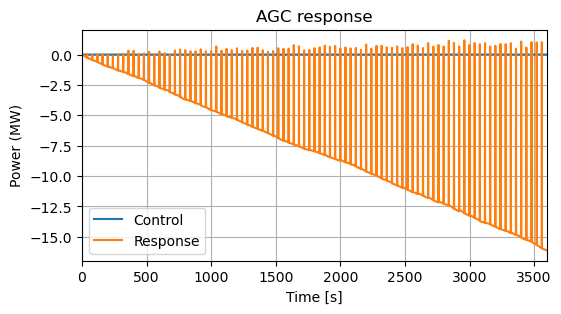

In [10]:
sse.plot_agc()

In [11]:
# ssa.TDS.save_output()

/home/jwang175/andes/andes/plot.py:800: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/home/jwang175/andes/andes/plot.py:800: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/home/jwang175/andes/jwang/notes/cosim_plot.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


Total cost=296608.02


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
/home/jwang175/mambaforge/envs/andes/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


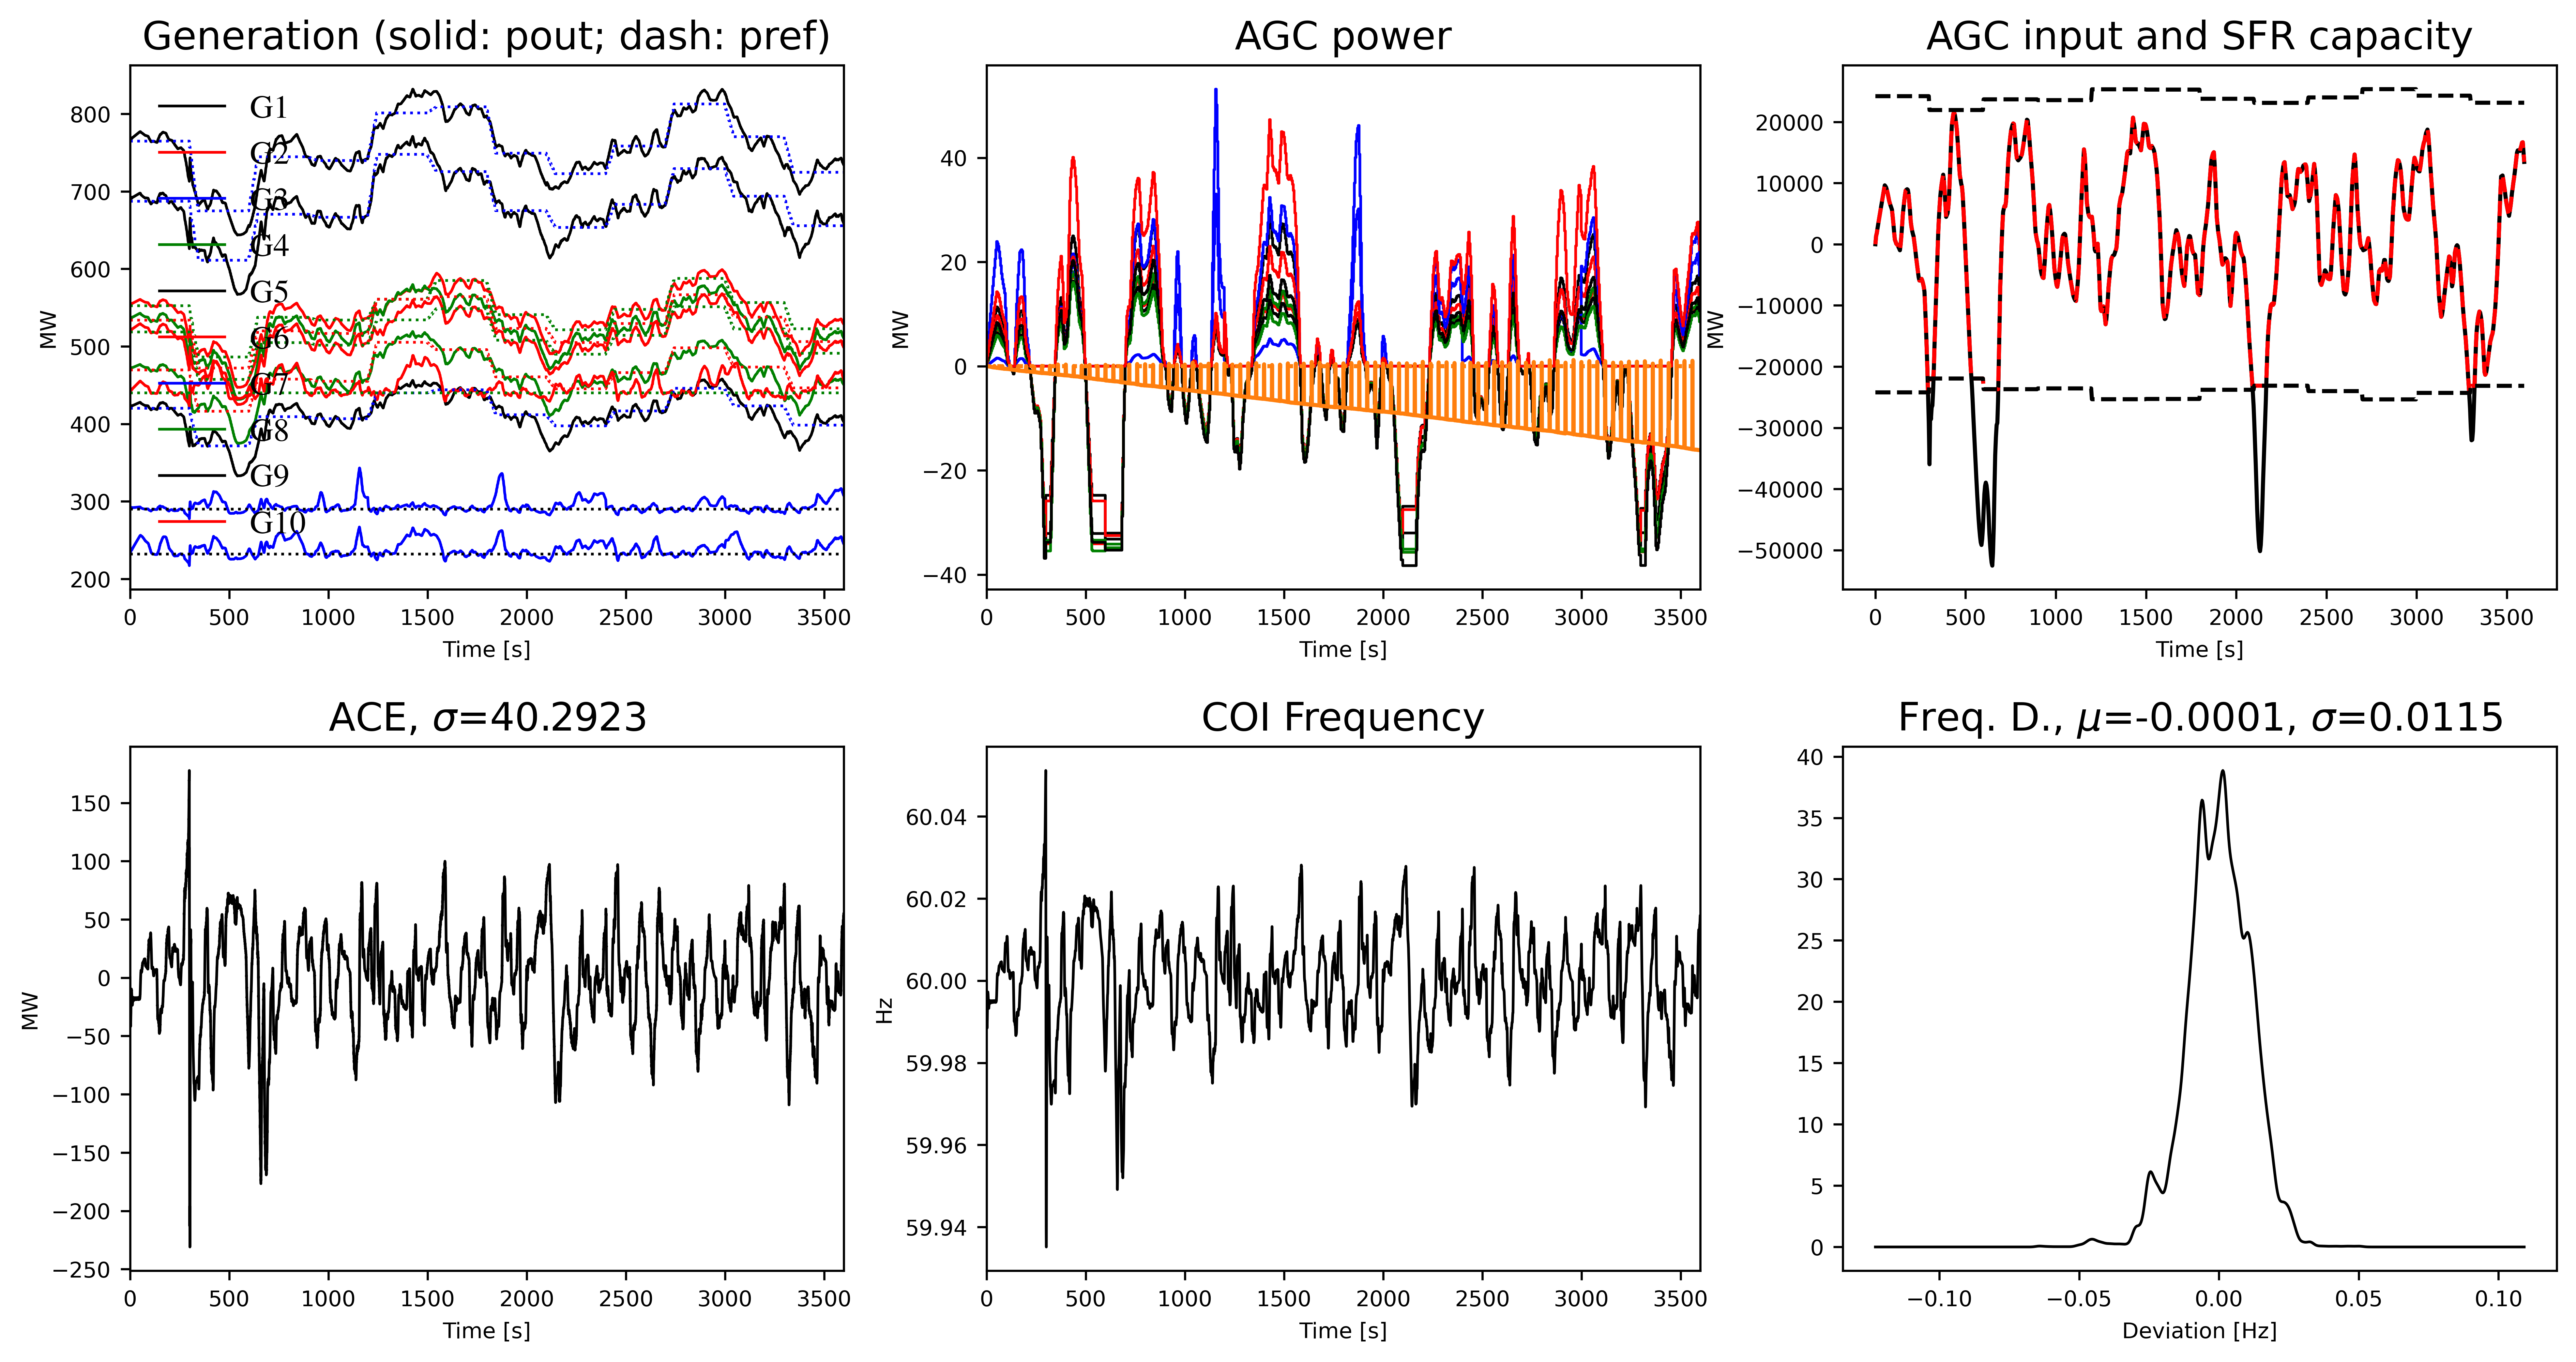

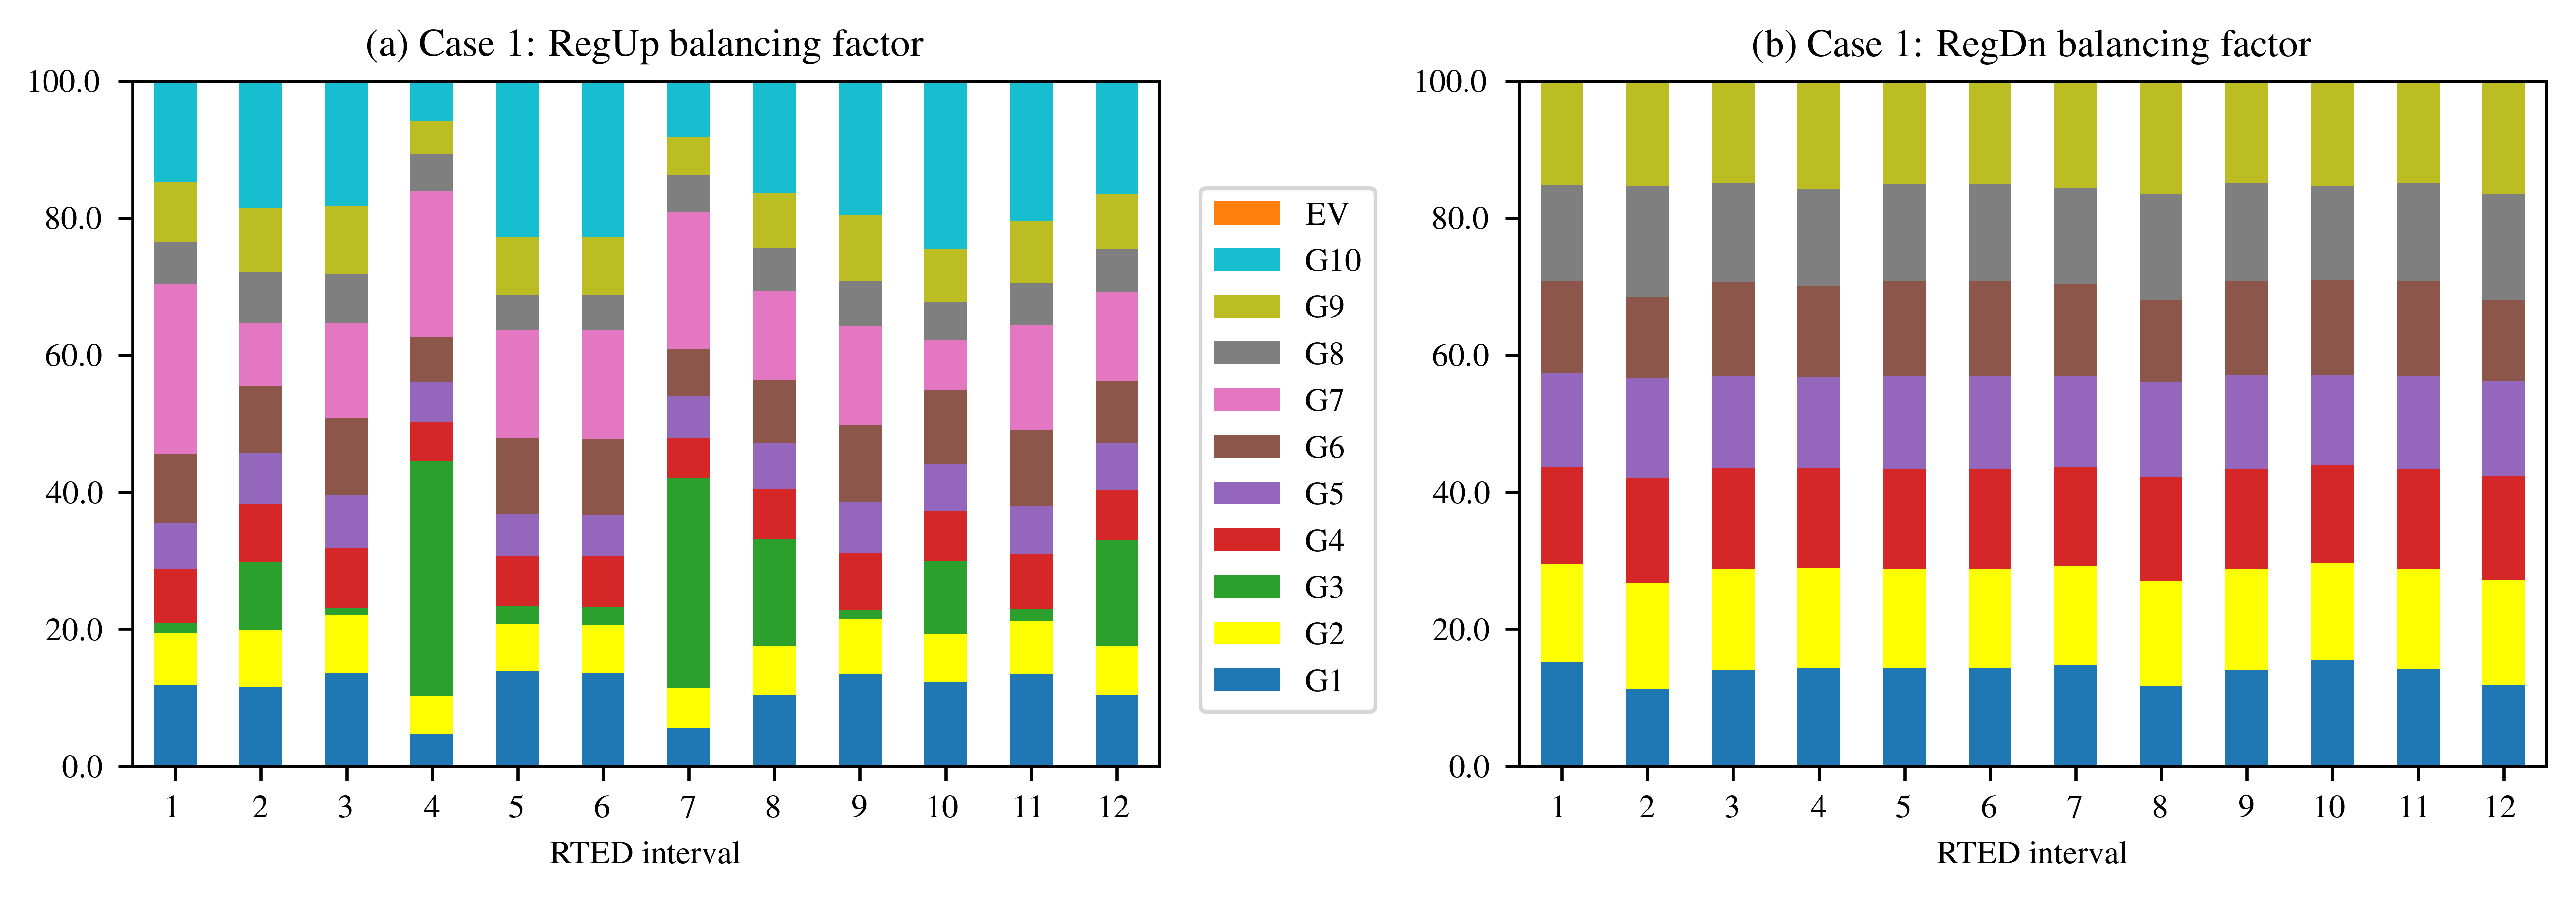

In [12]:
%run -i 'cosim_plot.py'

In [13]:
# plot the AGC signal

# figa, axa = plt.subplots()
# axa.plot(range(0, 3600, 4),
#          ssa.config.mva * agc_out.values[10:, 1:].reshape(900, 1),
#          color='tab:orange')
# axa.plot(range(0, 3600, 4),
#          ssa.config.mva * agc_in.values[10:, 1:].reshape(900, 1),
#          color='tab:red')
# ssa.TDS.plt.plot(ssa.TGOV1N.paux,
#                  linestyles=['-'],
#                  yheader=yheader,
#                  ytimes=ssa.config.mva,
#                  legend=False, show=False,
#                  title=r'AGC power', ylabel='MW',
#                  fig=figa, ax=axa, style='default',
#                  left=1000, right=2000)
# axa.legend(['AGC_out-EV', 'AGC_in-EV'])

In [14]:
sim_name = '_S'
cosim_out.to_csv('cosim_18' + sim_name + '_out.csv', index=False)
sse_out.to_csv('cosim_18' + sim_name + '_sse.csv', index=False)
bu_df.to_csv('cosim_18' + sim_name + '_bu.csv', index=False)
bd_df.to_csv('cosim_18' + sim_name + '_bd.csv', index=False)
pg_df.to_csv('cosim_18' + sim_name + '_pg.csv', index=False)
agc_mile.to_csv('cosim_18' + sim_name + '_agcm.csv', index=False)
sfr_res.to_csv('cosim_18' + sim_name + '_sfr.csv', index=False)
ev_agc.to_csv('cosim_18' + sim_name + '_evagc.csv', index=False)
ev_soc.iloc[0:800].to_csv('cosim_18' + sim_name + '_evsoc1.csv', index=False)
ev_soc.iloc[800:].to_csv('cosim_18' + sim_name + '_evsoc2.csv', index=False)
sse.ev.to_csv('cosim_18' + sim_name + '_evdata.csv', index=False)

import csv
new_path = open('cosim_18' + sim_name + '_rted.csv', 'w')
z = csv.writer(new_path)
for new_k, new_v in rted_res.items():
    z.writerow([new_k, new_v])
new_path.close()

In [15]:
# split -l 4 index.txt split_file
# !ls -lh